# Post-processing (2/n)

Visually inspect the data summary, find the EM run with the best likelihood for each dataset, and output final result files.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter

from myconfig import ROOT_DIR, DATA_DIR, DATASET_DIR

In [2]:
%matplotlib inline

In [3]:
conditions = pd.read_csv(DATASET_DIR/'01-simulation01'/'conditions.tsv', sep='\t')

In [4]:
loglik = pd.read_pickle(DATA_DIR/'post-batch'/'01-simulation01'/'loglik.pkl.bz2')
param_dist = pd.read_pickle(DATA_DIR/'post-batch'/'01-simulation01'/'param-accuracy.pkl.bz2')
recon_pcorrect = pd.read_pickle(DATA_DIR/'post-batch'/'01-simulation01'/'recon-accuracy.pkl.bz2')

In [5]:
loglik.loc[loglik['loglik'].isna()]

,conditionID,data_rep,fit_rep,loglik
422,cond05,3,3,NaN
441,cond05,5,2,NaN


In [6]:
!tail -n15 ../../data/batch/01-simulation01/log/240628-fitting-sbatch1.sh.stdxxx-423

  File "/opt/conda/lib/python3.10/site-packages/colaml/treeStats.py", line 170, in compute
    assert (
AssertionError: tfdns < 0 in []: []
2024-06-28 15:00:13,855:WARNING:root:Finding next ss_method...
2024-06-28 15:00:13,887:ERROR:root:Fitting failed. Try with another seed.
Traceback (most recent call last):
  File "/opt/conda/bin/colaml", line 8, in <module>
    sys.exit(main())
  File "/opt/conda/lib/python3.10/site-packages/colaml/__main__.py", line 698, in main
    _subcommand_callers[args.subcommand](args)
  File "/opt/conda/lib/python3.10/site-packages/colaml/__main__.py", line 576, in fit
    _fit_callers[args.model](args)
  File "/opt/conda/lib/python3.10/site-packages/colaml/__main__.py", line 374, in fit_mmm
    raise RuntimeError(msg)
RuntimeError: Fitting failed. Try with another seed.


In [7]:
!tail -n15 ../../data/batch/01-simulation01/log/240628-fitting-sbatch1.sh.stdxxx-442

  File "/opt/conda/lib/python3.10/site-packages/colaml/treeStats.py", line 170, in compute
    assert (
AssertionError: tfdns < 0 in []: []
2024-06-28 14:58:36,909:WARNING:root:Finding next ss_method...
2024-06-28 14:58:36,923:ERROR:root:Fitting failed. Try with another seed.
Traceback (most recent call last):
  File "/opt/conda/bin/colaml", line 8, in <module>
    sys.exit(main())
  File "/opt/conda/lib/python3.10/site-packages/colaml/__main__.py", line 698, in main
    _subcommand_callers[args.subcommand](args)
  File "/opt/conda/lib/python3.10/site-packages/colaml/__main__.py", line 576, in fit
    _fit_callers[args.model](args)
  File "/opt/conda/lib/python3.10/site-packages/colaml/__main__.py", line 374, in fit_mmm
    raise RuntimeError(msg)
RuntimeError: Fitting failed. Try with another seed.


These are known issues concerning sufficient stats compuation due to numerical instability (Fd -> 0).

In [8]:
best_runs = pd.merge(loglik, conditions).loc[
    lambda df: df.groupby(['conditionID','data_rep'])['loglik'].idxmax()
]

In [9]:
best_param_dist = pd.merge(best_runs, param_dist)
best_recon_pcorrect = pd.merge(best_runs, recon_pcorrect)

In [10]:
best_param_dist.loc[best_param_dist.isna().any(axis=1)]

,conditionID,data_rep,fit_rep,loglik,lmax,ncat,ntips,nOGs,cpy_change_rates,cpy_root_probs,cat_switch_rates,cat_root_probs
90,cond10,1,9,-165416.098747,2,1,128,4000,0.010926,0.020503,NaN,NaN
91,cond10,2,8,-220910.025463,2,1,128,4000,0.003020,0.013940,NaN,NaN
92,cond10,3,3,-216248.096758,2,1,128,4000,0.009458,0.008086,NaN,NaN
93,cond10,4,2,-269695.200325,2,1,128,4000,0.004318,0.012795,NaN,NaN
94,cond10,5,3,-219377.903961,2,1,128,4000,0.003610,0.000811,NaN,NaN
95,cond10,6,7,-129188.198476,2,1,128,4000,0.016375,0.003274,NaN,NaN
96,cond10,7,2,-187870.160067,2,1,128,4000,0.006357,0.013387,NaN,NaN
97,cond10,8,2,-272317.076696,2,1,128,4000,0.004989,0.009688,NaN,NaN
98,cond10,9,5,-175557.678306,2,1,128,4000,0.009467,0.011899,NaN,NaN
99,cond10,10,10,-212333.359315,2,1,128,4000,0.004478,0.021703,NaN,NaN


In [11]:
default = conditions.iloc[0]

cond_groups = {
    key: pd.concat([
        default.to_frame().T, 
        conditions[conditions[key] != default[key]]
    ]).sort_values(by=key)
    for key in ['lmax', 'ncat', 'ntips', 'nOGs']
}

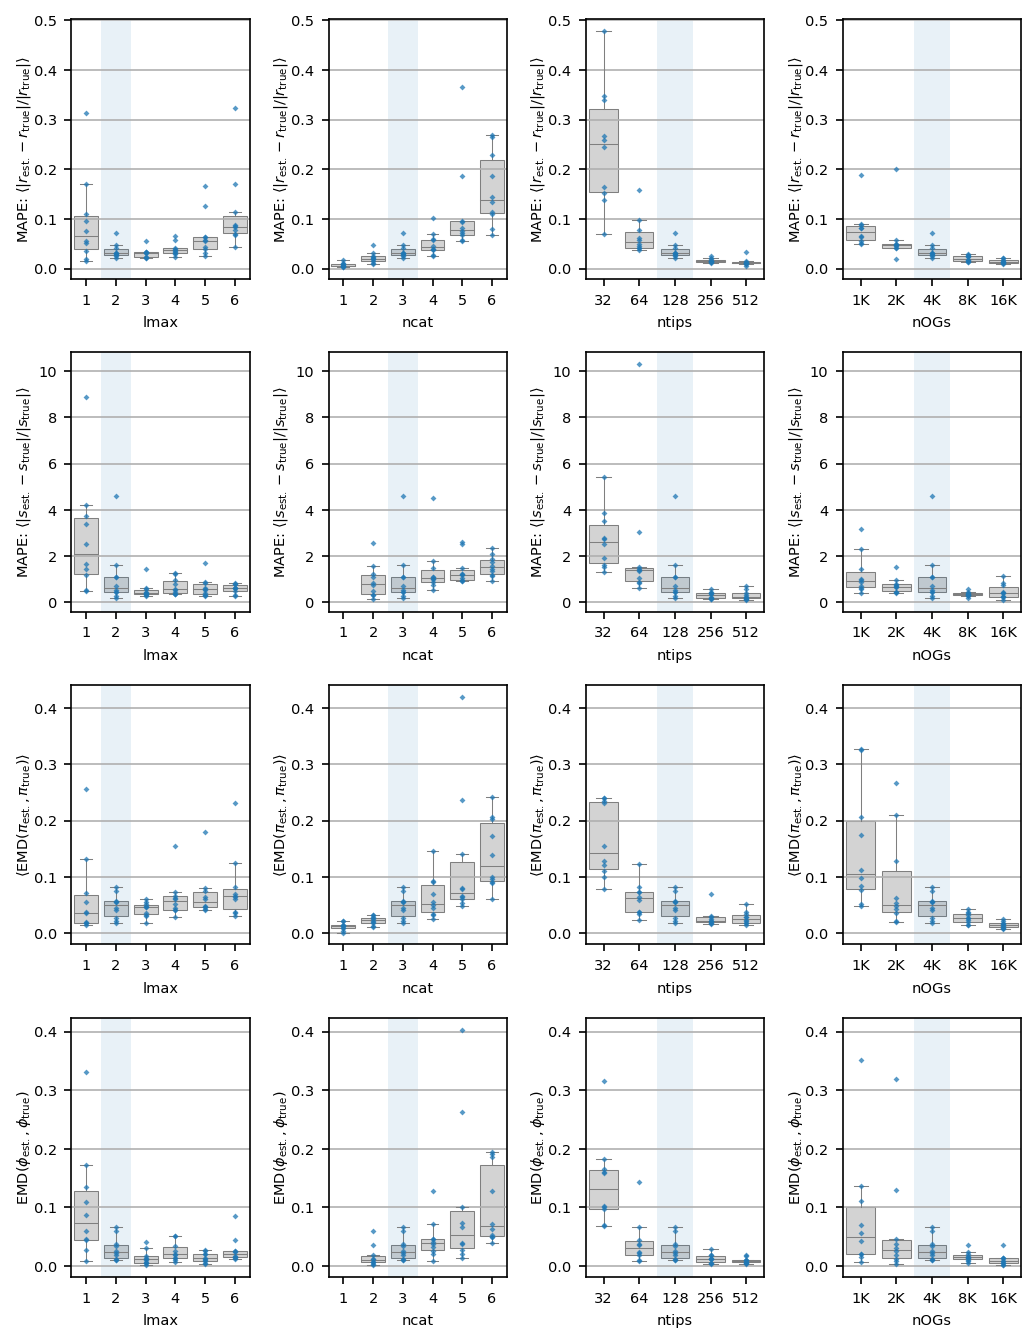

In [12]:
mm = 1 / 25.4
panel_cols = ['lmax', 'ncat', 'ntips', 'nOGs']
panel_rows = ['cpy_change_rates', 'cat_switch_rates', 'cpy_root_probs', 'cat_root_probs']
labels = dict(
    cpy_change_rates=r'MAPE: $\langle |r_\mathrm{est.} - r_\mathrm{true}| / |r_\mathrm{true}| \rangle$', 
    cat_switch_rates=r'MAPE: $\langle |s_\mathrm{est.} - s_\mathrm{true}| / |s_\mathrm{true}| \rangle$', 
    cpy_root_probs=r'$\langle \mathrm{EMD}(\pi_\mathrm{est.}, \pi_\mathrm{true}) \rangle$', 
    cat_root_probs=r'$\mathrm{EMD}(\phi_\mathrm{est.}, \phi_\mathrm{true})$'
)

with plt.rc_context({'font.size': 7}):
    fig, axes = plt.subplots(
        len(panel_rows), len(panel_cols), sharex='col', sharey='row', 
        dpi=150, figsize=(178*mm, 230*mm), layout='tight'
    )
    for key, axc in zip(panel_cols, axes.T):
        cond_grp = cond_groups[key]

        data = best_param_dist[best_param_dist['conditionID'].isin(cond_grp['conditionID'])]

        for par, ax in zip(panel_rows, axc):
            sns.stripplot(
                data=data, x=key, y=par, order=cond_grp[key], 
                jitter=0, marker='D', alpha=0.75, size=2, ax=ax,
            )
            sns.boxplot(
                data=data, x=key, y=par, order=cond_grp[key], 
                linewidth=0.5, color='lightgray', fliersize=0, ax=ax
            )

            dx = cond_grp[key].to_list().index(default[key])
            ax.axvspan(dx-0.5, dx+0.5, alpha=0.1, fc='tab:blue')
            ax.set_ylabel(labels[par], visible=True, labelpad=0.3)
            ax.set_xlabel(key, visible=True)
            ax.xaxis.set_tick_params(labelbottom=True)
            ax.yaxis.set_tick_params(labelleft=True)
            ax.yaxis.grid()
            
            if key == 'nOGs':
                ax.set_xticklabels(cond_grp[key].astype(str).str.replace('000', 'K'))
    
    fig.align_ylabels()


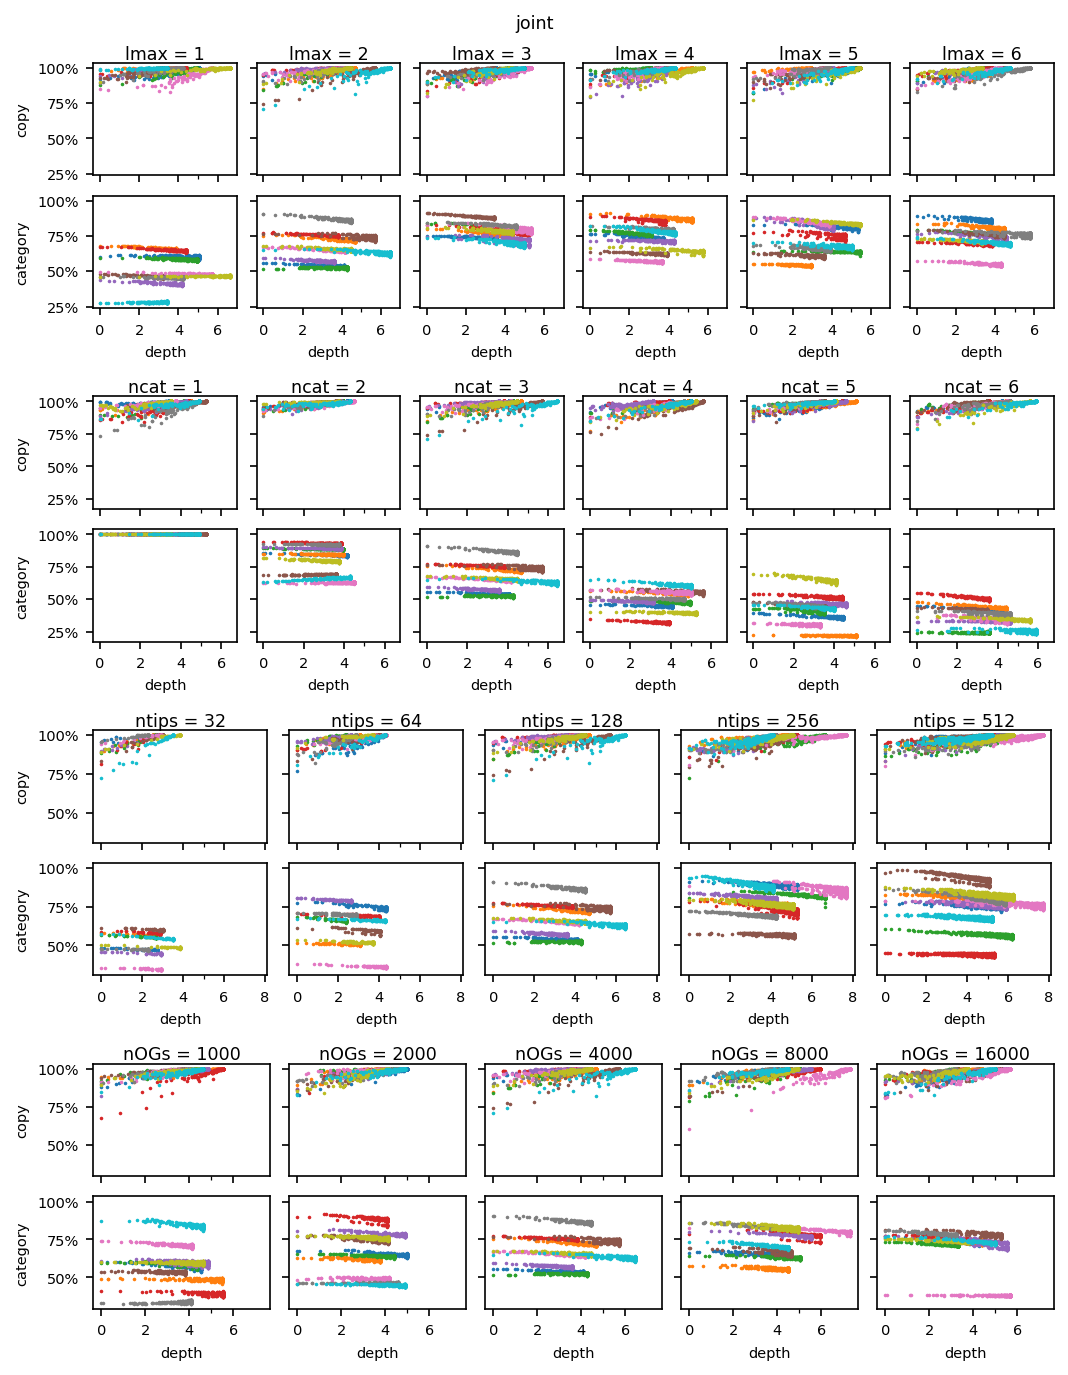

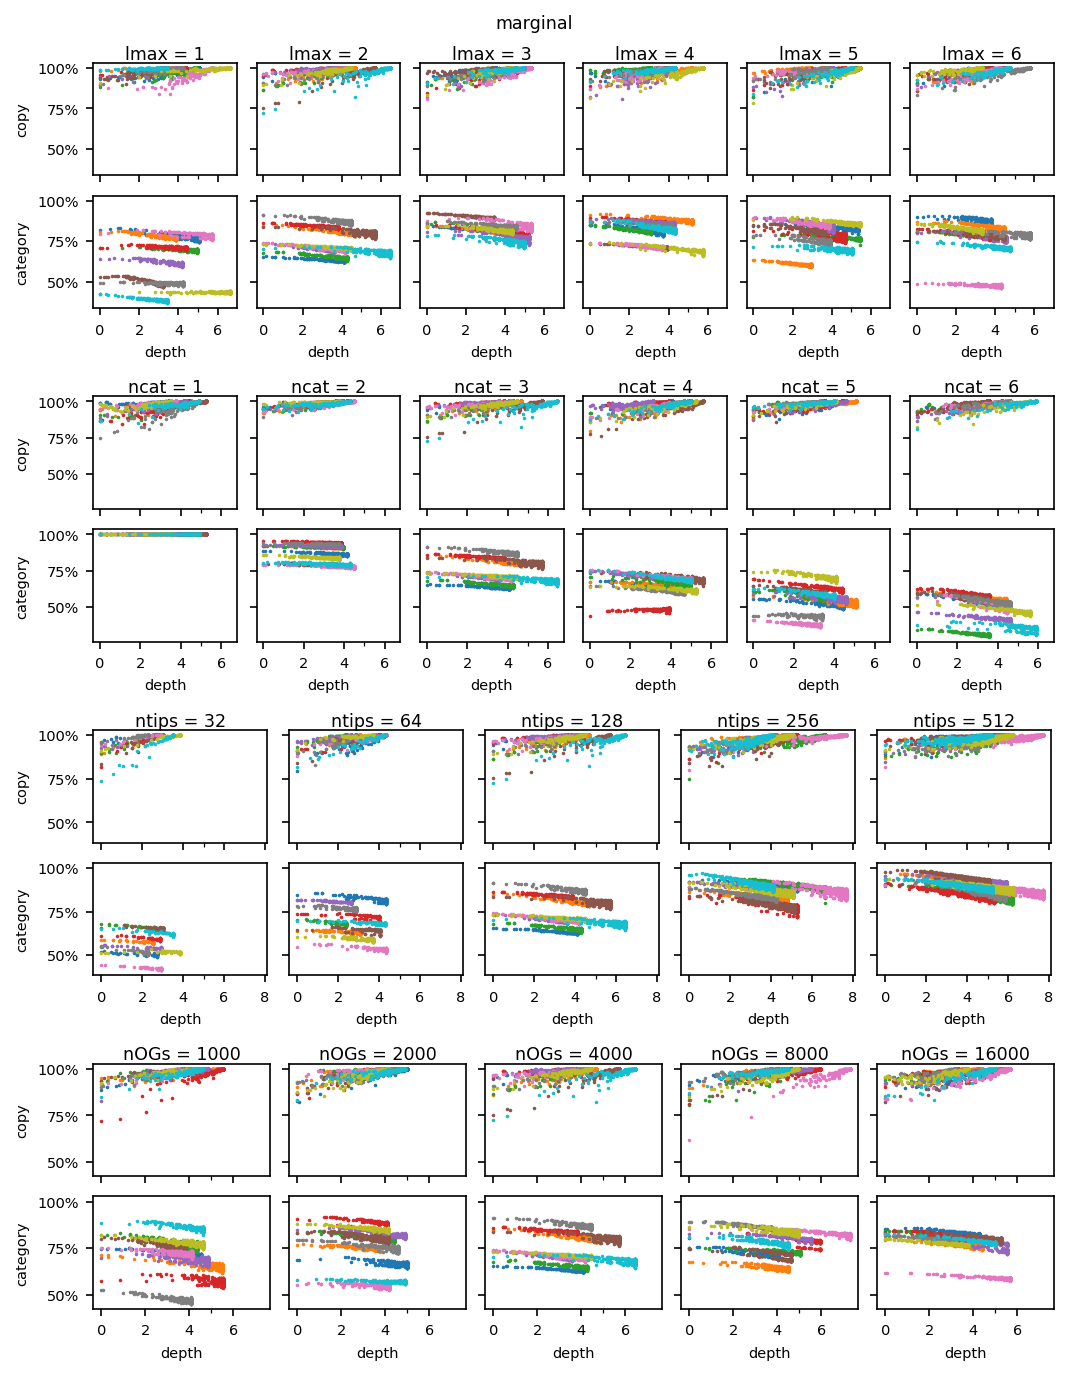

In [13]:
recon_grp = best_recon_pcorrect.groupby('conditionID')


with plt.rc_context({'font.size': 7}):
    for method in ('joint', 'marginal'):
        fig = plt.figure(layout='constrained', figsize=(178*mm, 230*mm), dpi=150)
        subfigs = fig.subfigures(len(cond_groups), wspace=0.07)

        for (key, conds), subfig in zip(cond_groups.items(), subfigs):
            axes = subfig.subplots(2, len(conds), sharex=True, sharey=True, gridspec_kw=dict(hspace=0.0001))
            for (_, cond), ax in zip(conds.iterrows(), axes[0]):
                for rep, tmp in recon_grp.get_group(cond.conditionID).groupby('data_rep'):
                    tmp.plot.scatter(x='depth', y=(method,'pcorrect_cpy'), s=0.5, c=f'C{rep-1}', ax=ax)
                ax.set_ylabel('copy')
                ax.set_title(f'{key} = {cond[key]}', pad=0.1)

            for (_, cond), ax in zip(conds.iterrows(), axes[1]):
                for rep, tmp in recon_grp.get_group(cond.conditionID).groupby('data_rep'):
                    tmp.plot.scatter(x='depth', y=(method,'pcorrect_cat'), s=0.5, c=f'C{rep-1}', ax=ax)
                ax.set_ylabel('category')

            for ax in axes.flatten():
                ax.margins(0.05)
                ax.xaxis.set_major_locator(plt.MultipleLocator(2))
                ax.yaxis.set_major_locator(plt.MultipleLocator(0.25))
                ax.yaxis.set_major_formatter(PercentFormatter(1))
        
        fig.suptitle(method)

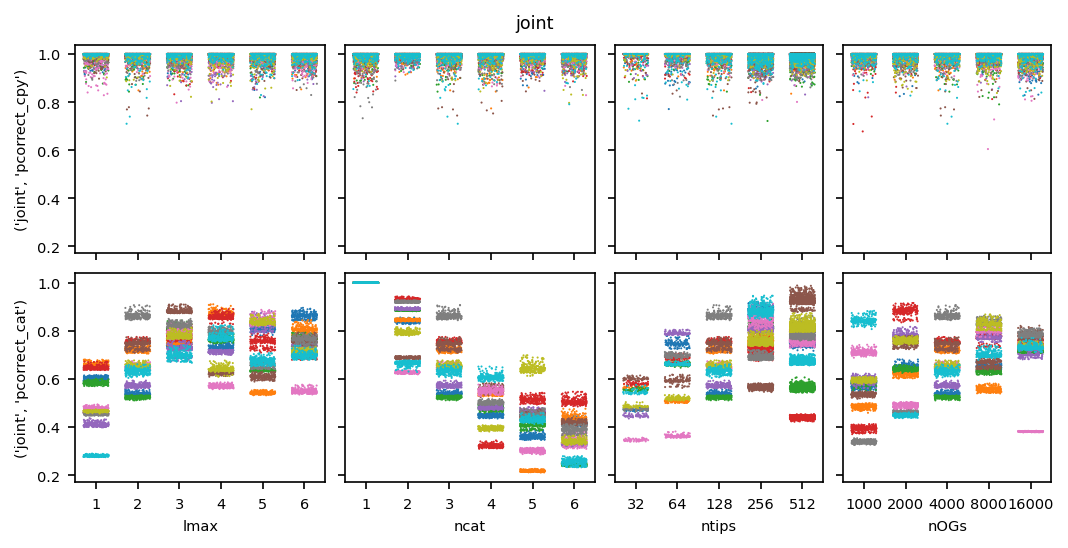

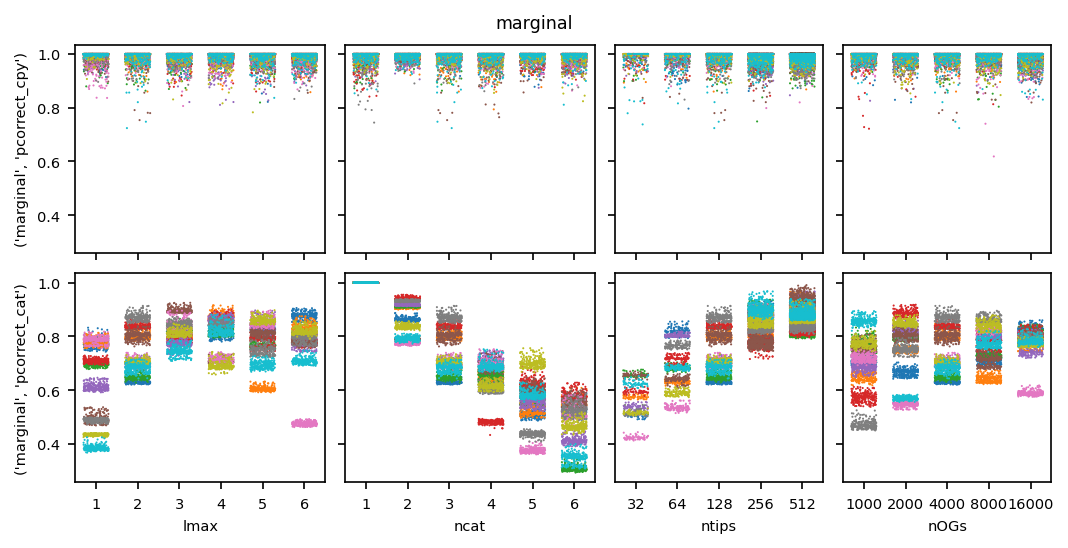

In [14]:
with plt.rc_context({'font.size': 7}):
    for method in ('joint', 'marginal'):
        fig, axes = plt.subplots(
            2, len(cond_groups), figsize=(178*mm, 90*mm), dpi=150, 
            gridspec_kw=dict(width_ratios=[*map(len, cond_groups.values())]), 
            layout='constrained', sharey=True, sharex='col'
        )
        
        for (key, conds), axc in zip(cond_groups.items(), axes.T):
            data = pd.concat(map(recon_grp.get_group, conds['conditionID']))

            for which, ax in zip(('pcorrect_cpy', 'pcorrect_cat'), axc):    
                sns.stripplot(
                    data=data, x=key, y=(method, which), 
                    dodge=False, jitter=0.3, s=1, #alpha=0.2, 
                    order=conds[key], hue='data_rep', palette='tab10', legend=False, ax=ax
                )
        
        fig.suptitle(method)

In [15]:
best_param_dist.to_csv(ROOT_DIR/'results'/'simulaton-param-dist.tsv', sep='\t')
best_recon_pcorrect.to_csv(ROOT_DIR/'results'/'simulaton-recon-pcorrect.tsv', sep='\t')